Now analysis of parsed data from part 1.

Useful ref http://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

http://stackoverflow.com/questions/21828398/what-is-the-difference-between-pandas-agg-and-apply-function

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
%load_ext watermark
%watermark -a 'Robin Cole' -u -d -v -p numpy,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Robin Cole 
last updated: 2016-09-27 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1


## Helper functions

In [2]:
def query_data(Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    temp = d[Col][(d['structure'] == structure) & (d['metric'] == metric)]
    return temp

In [3]:
def diff_percent(a,ref):
    return 100*((a-ref)/ref)

print(diff_percent(25.0,100.0))

-75.0


In [39]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [34]:
my_wilcox([1,2,3,4,6,7,2,352,3])

/Users/robincole/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


0.0075792819433897285

In [5]:
def bland_altman_plot(data1, data2, structure, metric, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    z_stat, p_val = wilcoxon(data1, data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    diff_p = diff_percent(data1, data2)
    sd        = np.std(diff_p, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff_p, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('Dose (Gy)')
    plt.ylabel('Difference (%)')
    plt.title('p value of ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)

## Import and clean data 

In [6]:
d = pd.read_csv('AAA_Dm_data.csv')

Drop entries with no values, and calculate percent difference

In [7]:
d = d[d.AAA != 0]    # drop zero rows
d = d[d.Dm != 0]    # drop zero rows

In [8]:
d = d[d.structure != 'L Brachial plex']   # drop these
d = d[d.structure != 'Both Lungs']
d = d[d.metric != 'V20GY']
d = d[d.metric != 'V30GY']
d = d[d.metric != 'V40GY']
d = d[d.metric != 'V50GY']
d = d[d.metric != 'V55GY']
d = d[d.metric != 'DRX']

In [9]:
d['diff'] = diff_percent(d.Dm, d.AAA)  # create % difference col

In [10]:
d.head()

,Case,structure,metric,AAA,Dm,diff
0,Case1,PTV CHEST,D2%,70.006151,69.599396,-0.581028
1,Case1,PTV CHEST,D5%,69.602983,69.044564,-0.802292
2,Case1,PTV CHEST,D50%,65.560826,65.457641,-0.157389
3,Case1,PTV CHEST,D95%,57.272270,56.747946,-0.915495
4,Case1,PTV CHEST,D99%,55.580473,54.672556,-1.633518


In [11]:
# d.describe()

In [12]:
# d.loc[d['diff'].idxmax()] # Some large differences for L Brachial plex, could be naming issue

In [13]:
# d[d['diff']>100.0]   # see the extreme cases

In [14]:
d = d[d['diff']<100.0] # drop extreme cases where difference is greater than 100%

# How do the metrics compare for PTV? Extract difference (%) by metric for PTV

In [15]:
d_PTV =  d[d['structure']  == 'PTV CHEST'].groupby(['metric'])
d_PTV = d_PTV.diff.mean()  # get mean diff values
d_PTV.sort_values(ascending=False) #d_PTV.groups.keys()

metric
DHI        9.024376
DSD        8.042449
DMAX       1.549591
D0.1CC     1.075630
D2%        1.009428
D5%        0.899626
D1CC       0.837025
D50%       0.350911
V5GY       0.000000
V12.5GY    0.000000
D95%      -1.053558
D99%      -1.594362
Name: diff, dtype: float64

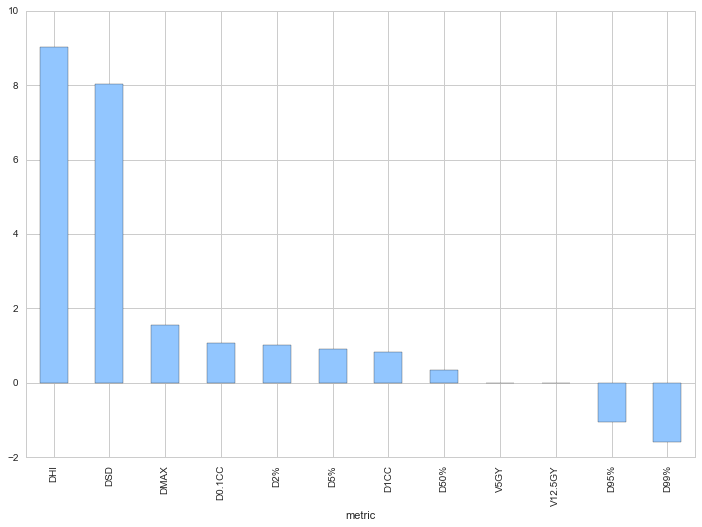

In [16]:
d_PTV.sort_values(ascending=False).plot(kind='bar', figsize=(12,8))

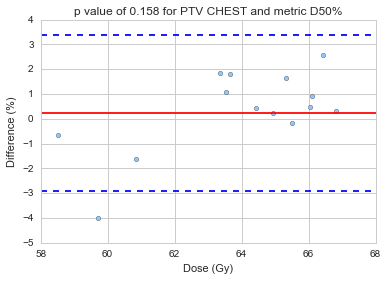

In [17]:
fig = plt.figure(figsize=(6, 4))
structure = 'PTV CHEST'
metric = 'D50%'
bland_altman_plot(query_data('Dm', structure, metric), query_data('AAA',structure, metric), structure, metric)
plt.show()

Histograms of data PTV data

/Users/robincole/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


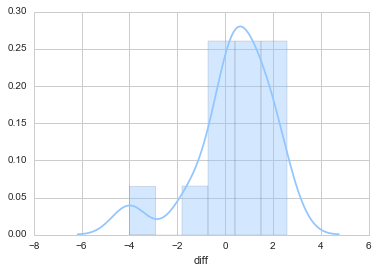

In [18]:
#ax2 = sns.distplot(query_data('diff', 'PTV CHEST', 'D50%'))   # quick test

fig = plt.figure(figsize=(6, 4))
data=query_data('diff', 'PTV CHEST', 'D50%')

# plt.subplot(1, 2, 1)
ax2 = sns.distplot(data)

#plt.subplot(1, 2, 2)
#ax = sns.violinplot(data)  

# Extract stats grouped by structure for D50% metric

In [19]:
stats = {  'Mean' : 'mean', 'Variance':'var', 'SEM':'sem', 'Counts':'count'} 

aggregations = {'diff': stats, 'AAA': stats, 'Dm': stats}

res_table = d[d['metric']  == 'D50%'].groupby(['structure']).agg(aggregations)
res_table

diff                                  AAA                   \
              Variance       SEM Counts      Mean  Variance       SEM Counts   
structure                                                                      
Foramen      50.995699  1.980592     13 -5.058686  3.029865  0.482770     13   
Heart       127.408121  3.016717     14  8.372282  1.599139  0.337971     14   
Lt_Lung      33.384712  1.544222     14 -5.437559  1.433543  0.319994     14   
Oesophagus   91.743879  2.559909     14  1.256873  7.751505  0.744096     14   
PTV CHEST     2.780158  0.445626     14  0.350911  5.201402  0.609532     14   
Rt_Lung      39.947631  1.689202     14 -5.027630  1.128225  0.283879     14   

                             Dm                              
                 Mean  Variance       SEM Counts       Mean  
structure                                                    
Foramen      1.532283  2.817111  0.465511     13   1.451497  
Heart        1.010267  1.536309  0.331265     14   1.006369  
Lt_Lung      1.166398  1.451211  0.321960     14   1.135430  
Oesophagus   1.297815  7.247245  0.719486     14   1.268311  
PTV CHEST   63.821273  8.678068  0.787313     14  64.063104  
Rt_Lung      0.957381  1.102932  0.280679     14   0.925061

# Mean difference grouped by structure and metric for difference (%) only

In [20]:
res_table2 = d.groupby(['structure', 'metric'],as_index=False).mean()  # just get mean values 

In [21]:
diff_table = res_table2.pivot(index='structure', columns='metric', values='diff')  # pivot table for diff values
diff_table

metric,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DSD,V12.5GY,V5GY
structure,,,,,,,,,,,,
Foramen,-2.745287,-2.747195,-2.703956,-2.732047,-5.058686,12.854786,19.582669,2.907343,-2.445338,-2.195452,-29.416592,-6.255900
Heart,-5.384663,2.296446,-1.078786,-1.497848,8.372282,34.863062,26.436916,-9.622790,2.578635,-2.770943,-15.894746,-4.184432
Lt_Lung,0.674173,0.747234,0.699098,0.919857,-5.437559,3.695552,2.869290,6.845067,1.106428,0.608868,0.735817,4.653442
Oesophagus,-1.876384,-1.666487,-1.700855,-1.591563,1.256873,28.833957,8.221215,-2.492459,-2.002628,-1.725985,-24.588094,-1.943005
PTV CHEST,1.075630,0.837025,1.009428,0.899626,0.350911,-1.053558,-1.594362,9.024376,1.549591,8.042449,0.000000,0.000000
Rt_Lung,0.592606,0.336425,1.079684,1.679479,-5.027630,-4.517919,-5.014959,6.999853,0.948142,1.223104,-8.594444,3.501837


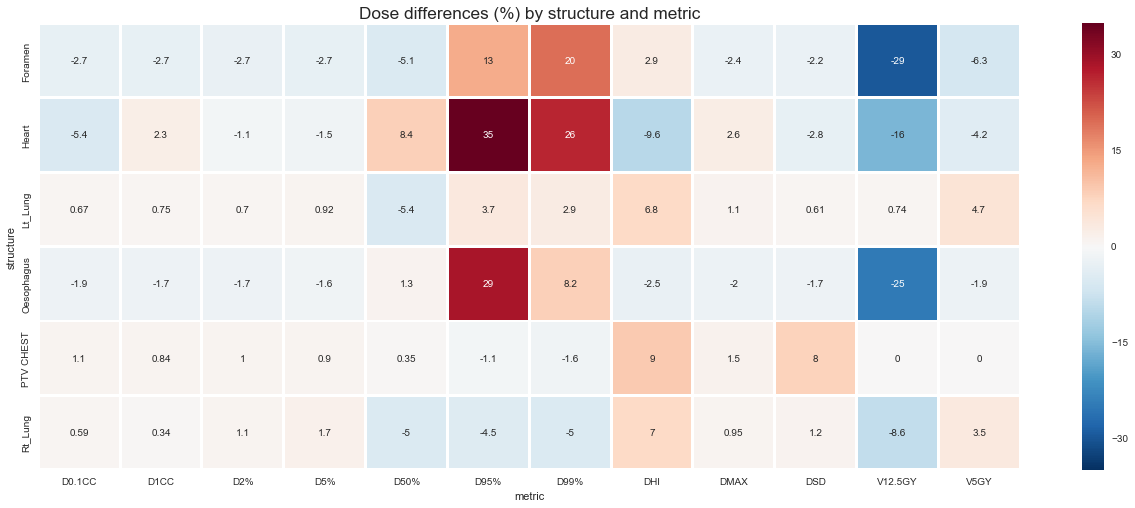

In [22]:
plt.figure(figsize=(22, 8))
ax1 = sns.heatmap(diff_table, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Dose differences (%) by structure and metric', size='xx-large')

In [23]:
d[(d['structure'] == 'Heart') & (d['metric'] == 'D95%')] # show data for single structure and metric

,Case,structure,metric,AAA,Dm,diff
255,Case1,Heart,D95%,0.152595,0.190120,24.591114
273,Case11,Heart,D95%,0.210060,0.263952,25.655575
291,Case12,Heart,D95%,0.350915,0.365865,4.260106
309,Case13,Heart,D95%,0.110997,0.137072,23.491588
345,Case16,Heart,D95%,0.050923,0.065459,28.544222
363,Case17,Heart,D95%,0.490982,0.558041,13.658002
381,Case18,Heart,D95%,0.030323,0.059717,96.936040
399,Case22,Heart,D95%,1.022610,0.966026,-5.533233
417,Case23,Heart,D95%,0.005815,0.008445,45.218978
435,Case25,Heart,D95%,0.389428,0.411698,5.718591


In [24]:
metrics_list = diff_table.keys()  # get the keys for later
metrics_list

Index(['D0.1CC', 'D1CC', 'D2%', 'D5%', 'D50%', 'D95%', 'D99%', 'DHI', 'DMAX',
       'DSD', 'V12.5GY', 'V5GY'],
      dtype='object', name='metric')

In [25]:
structures_list = diff_table.index.values
structures_list

array(['Foramen', 'Heart', 'Lt_Lung', 'Oesophagus', 'PTV CHEST', 'Rt_Lung'], dtype=object)

## Get wilcoxon p value of differences 

In [40]:
test = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D5%')]['diff']
my_wilcox(test)  # test

0.025842854459788903

In [41]:
i = len(structures_list)
j = len(metrics_list)
wilcox_data = np.zeros((i,j))  # init an empty array

In [42]:
j = 0
for structure in structures_list:
    i = 0
    for metric in metrics_list:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['diff']
        wilcox_data[j][i] = my_wilcox(D)
        i = i + 1
    j = j+ 1  

/Users/robincole/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Convert to dataframe

In [43]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_list,    # 1st column as index
...              columns=metrics_list)  # 1st row as the column names

In [44]:
# wilcox_data_df

In [45]:
wilcox_data_df[wilcox_data_df<0.05]  #get only stat significant results

metric,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DSD,V12.5GY,V5GY
Foramen,0.001474,0.001474,0.001474,0.001474,0.019223,0.033047,NaN,NaN,0.001474,0.003346,0.027708,0.002218
Heart,NaN,NaN,NaN,NaN,0.047990,0.002366,0.017290,0.011008,NaN,0.007686,0.027708,0.011719
Lt_Lung,NaN,NaN,NaN,0.025843,0.003510,NaN,NaN,0.001225,NaN,NaN,NaN,0.005213
Oesophagus,0.000982,0.001225,0.000982,0.001225,NaN,0.016605,NaN,NaN,0.004649,0.005034,0.027708,0.001871
PTV CHEST,0.021944,0.021944,0.007630,0.025843,NaN,NaN,0.035465,0.003510,0.003510,0.010747,NaN,NaN
Rt_Lung,NaN,NaN,0.002329,0.000982,0.011008,0.035465,NaN,0.001523,0.039243,0.036658,NaN,0.005772


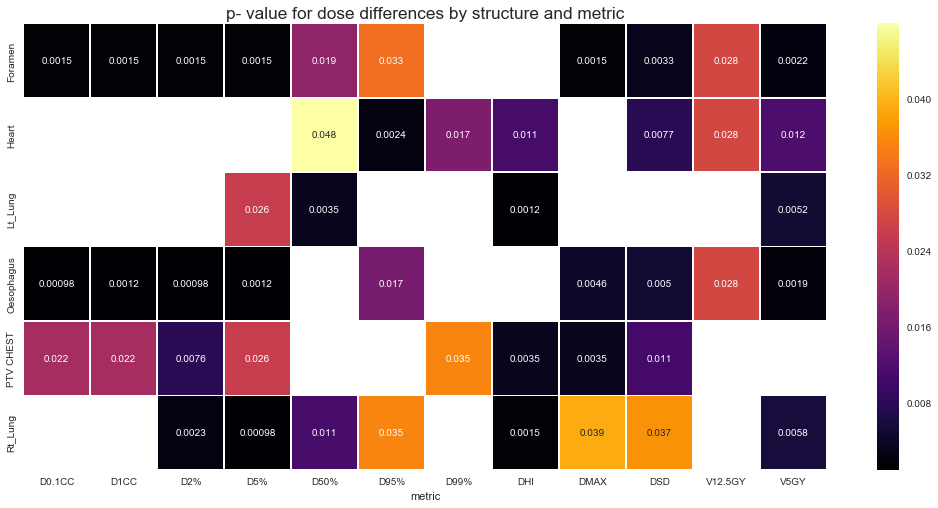

In [62]:
confidence = 0.05
plt.figure(figsize=(18, 8))
ax2 = sns.heatmap(wilcox_data_df[wilcox_data_df<confidence], annot=True, linewidths=.5,  cbar=True, cmap='inferno')
ax2.set_title('p- value for dose differences by structure and metric', size='xx-large')

Plot dose differences where statistically significant

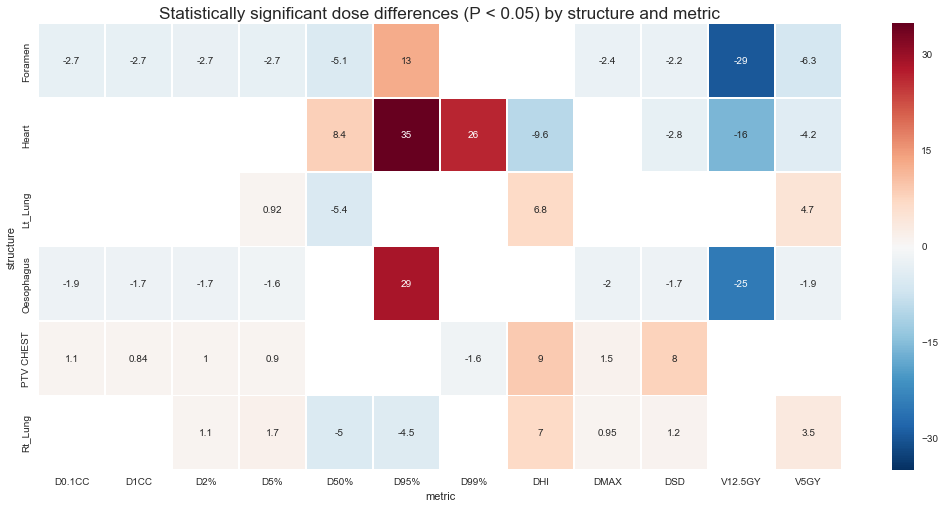

In [47]:
plt.figure(figsize=(18, 8))
ax3 = sns.heatmap(diff_table[wilcox_data_df<0.05] , annot=True, linewidths=.5)
ax3.set_title('Statistically significant dose differences (P < 0.05) by structure and metric', size='xx-large')
plt.savefig('fig3.png')

# Explore correlations by structure

In [117]:
diff_table = res_table2.pivot(index='structure', columns='metric', values='diff')  # pivot table for diff values
diff_table.reset_index(level=0, inplace=True)  

In [118]:
diff_table = diff_table.transpose()

In [119]:
diff_table

,0,1,2,3,4,5
metric,,,,,,
structure,Foramen,Heart,Lt_Lung,Oesophagus,PTV CHEST,Rt_Lung
D0.1CC,-2.74529,-5.38466,0.674173,-1.87638,1.07563,0.592606
D1CC,-2.7472,2.29645,0.747234,-1.66649,0.837025,0.336425
D2%,-2.70396,-1.07879,0.699098,-1.70086,1.00943,1.07968
D5%,-2.73205,-1.49785,0.919857,-1.59156,0.899626,1.67948
D50%,-5.05869,8.37228,-5.43756,1.25687,0.350911,-5.02763
D95%,12.8548,34.8631,3.69555,28.834,-1.05356,-4.51792
D99%,19.5827,26.4369,2.86929,8.22122,-1.59436,-5.01496
DHI,2.90734,-9.62279,6.84507,-2.49246,9.02438,6.99985


In [122]:
diff_table_correlations = diff_table.corr()
diff_table_correlations

""


In [123]:
plt.figure(figsize=(18, 8))
# ax3 = sns.heatmap(diff_table_correlations , annot=True, linewidths=.5)

# Explore correlations with material data for PTV

In [48]:
PTV_CT = pd.read_csv('PTV_HU_mean_dat.csv')  # import PTV density data

In [49]:
# PTV_CT

Get the PTV differences by metric and case

In [50]:
PTV_metrics = d[d['structure']  == 'PTV CHEST']
PTV_metrics = PTV_metrics.pivot(index='Case',columns='metric', values='diff')   #pivot on case and metric
PTV_metrics.reset_index(level=0, inplace=True)    # must convert the index back into a column

del PTV_metrics['V12.5GY'] # delete as no data for them
del PTV_metrics['V5GY']
# PTV_metrics

In [51]:
PTV_all = pd.merge(PTV_metrics, PTV_CT, how='inner', on=[ 'Case'])  # Merge on case 
PTV_all

metric,Case,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DSD,mean_HU,SD_HU,Volume_PTV
0,Case1,-1.646800,-0.623945,-0.581028,-0.802292,-0.157389,-0.915495,-1.633518,2.850494,-0.381971,-4.000000,-170.699,272.993,72.9
1,Case11,1.044115,0.638813,0.633493,0.642739,0.248408,-2.628825,-3.985440,14.416879,1.655380,13.253012,-551.763,279.318,25.2
2,Case12,2.279966,0.841989,0.910143,0.601526,0.489112,0.196736,-0.240510,3.974143,3.790751,1.282051,-478.357,276.233,38.6
3,Case13,2.109205,1.769138,1.792435,1.538511,1.636643,0.199115,-0.701292,8.237426,1.984733,6.756757,-426.137,296.692,44.7
4,Case14,0.812426,0.124380,0.221460,-0.112804,1.857474,0.445066,-0.370695,-0.878065,1.803752,0.000000,-432.742,277.356,35.4
5,Case16,2.355693,2.143460,2.600956,2.655809,0.429373,-0.788578,-1.580805,12.932591,2.277580,13.829787,-601.037,225.056,8.9
6,Case17,0.776133,1.198678,1.226977,1.144944,0.914957,-0.249615,-0.725107,6.958105,1.416853,2.777778,-275.691,359.180,77.3
7,Case18,2.824736,2.444145,2.870780,2.600269,1.813520,1.118255,1.763484,5.879023,3.427266,8.000000,-559.114,243.114,14.1
8,Case22,-0.101734,0.334918,0.264370,0.389630,0.299438,-0.164480,-0.190877,1.062469,-0.221239,2.352941,-363.164,293.196,35.6
9,Case23,2.312454,2.861348,2.438215,2.914029,1.090400,-0.589348,-1.212738,13.153501,1.972243,16.250000,-650.879,179.334,13.3


In [52]:
# sns.pairplot(PTV_all)

In [53]:
PTV_correlations = PTV_all.corr()
PTV_correlations

metric,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DSD,mean_HU,SD_HU,Volume_PTV
metric,,,,,,,,,,,,,
D0.1CC,1.000000,0.617233,0.906268,0.796625,0.400423,0.340136,0.359652,0.041674,0.914514,0.167788,-0.307133,-0.165632,-0.265892
D1CC,0.617233,1.000000,0.713018,0.894005,0.724770,0.686345,0.682077,-0.440057,0.454783,-0.164922,0.027899,0.202278,-0.050963
D2%,0.906268,0.713018,1.000000,0.928403,0.399044,0.350939,0.383756,0.061968,0.742861,0.194483,-0.225131,-0.166141,-0.225930
D5%,0.796625,0.894005,0.928403,1.000000,0.501597,0.445250,0.462563,-0.085805,0.586004,0.141344,-0.204784,-0.064768,-0.244744
D50%,0.400423,0.724770,0.399044,0.501597,1.000000,0.952730,0.908601,-0.831142,0.346984,-0.711395,0.550795,0.602303,0.458585
D95%,0.340136,0.686345,0.350939,0.445250,0.952730,1.000000,0.985553,-0.908367,0.318612,-0.800725,0.623298,0.579437,0.504028
D99%,0.359652,0.682077,0.383756,0.462563,0.908601,0.985553,1.000000,-0.885961,0.338290,-0.763182,0.573815,0.502432,0.448762
DHI,0.041674,-0.440057,0.061968,-0.085805,-0.831142,-0.908367,-0.885961,1.000000,0.001690,0.914548,-0.724182,-0.663931,-0.580604
DMAX,0.914514,0.454783,0.742861,0.586004,0.346984,0.318612,0.338290,0.001690,1.000000,0.052740,-0.225475,-0.098497,-0.174584


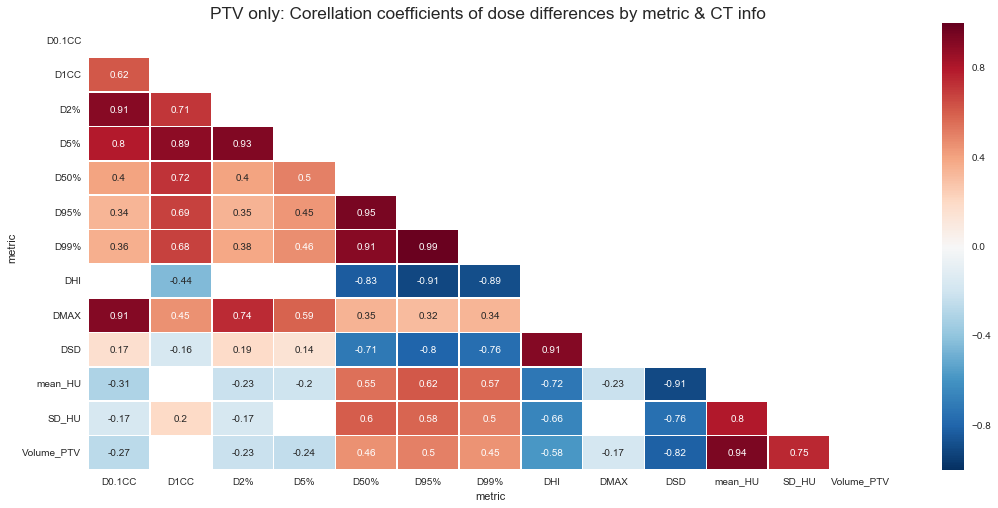

In [125]:
threshold = 0.1  # only show correlation coefficients greater than a threshold value
plt.figure(figsize=(18, 8)) 
mask = np.zeros_like(PTV_correlations, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True


ax4 = sns.heatmap(PTV_correlations[PTV_correlations.abs() > threshold], annot=True, mask=mask, linewidths=.5, center=0)
ax4.set_title('PTV only: Corellation coefficients of dose differences by metric & CT info ', size='xx-large')

# Investigate corellations 

/Users/robincole/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


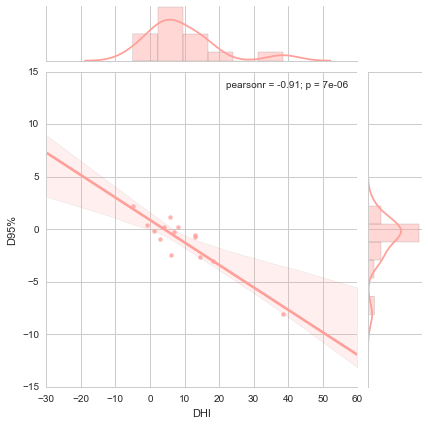

In [79]:
sns.jointplot("DHI", "D95%", data=PTV_all, kind="reg", color="r", size=6)

In [75]:
?sns.jointplot

# Testing

7.55692945586e-10
7.55692945586e-10


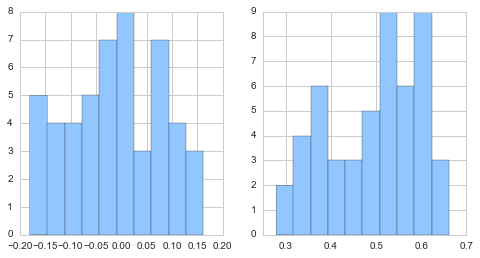

In [32]:
#Test of wilcoxon. See how size of distribution and difference in mean affect result p 

dist_diff = 0.5
samples = 50

mu, sigma = 0, 0.1 
s = np.random.normal(mu, sigma, samples)

mu2, sigma = 0+dist_diff, 0.1 
s2 = np.random.normal(mu2, sigma, samples)

fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(s)

plt.subplot(1, 2, 2)
plt.hist(s2)

z_stat, p_val = wilcoxon(s, s2)   # if only 1 value passed
print(p_val)

z_stat, p_val = wilcoxon(s-s2)   # if only 1 value passed
print(p_val)